# import function

In [1]:
import pickle
import numpy as np
from __future__ import print_function
import random
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Input
from keras.optimizers import Adam
from keras import callbacks
from keras import backend as K

from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten

/home/letitgo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/letitgo/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load dataset

In [2]:
def get_data(mins):
    mins = str(mins)
    with open ('data_list_' + mins, 'rb') as fp:
        data_list = np.array(pickle.load(fp))
        #data_list = np.reshape(data_list, (data_list.shape[0], data_list.shape[1], 1, data_list.shape[2]))
        data_list = np.reshape(data_list, (data_list.shape[0], 380, 5))
    with open ('label_list_' + mins, 'rb') as fp:
        label_list = np.array(pickle.load(fp))

    print(data_list.shape)
    print(label_list.shape)
    
    return data_list, label_list

# recall

In [3]:
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall

# precision

In [4]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.cast(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20), 'float32'))
    pred_positives = K.sum(K.cast(K.greater(K.clip(y_pred, 0, 1), 0.20), 'float32'))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

# F-measure function

In [5]:
def f_measure(y_true, y_pred):
    p_val = precision(y_true, y_pred)
    r_val = recall(y_true, y_pred)
    f_val = 2*p_val*r_val / (p_val + r_val)

    return f_val

# create model

In [6]:
def create_model():
    model = Sequential()
    
    model.add(LSTM(5, return_sequences=True,
               input_shape=(380, 5)))
    
    model.add(LSTM(5, return_sequences=True))
    model.add(LSTM(32))
    
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(Dense(64))
    model.add(BatchNormalization())    
    
    model.add(Dense(4,
                    activation='sigmoid'))

    adam = Adam(0.001)
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['acc', precision, recall, f_measure])

    model.summary()
    return model

## Load dataset and Spliting training set and validation set

In [7]:
train_size_rate = 0.9
BATCH_SIZE = 32
EPOCHS = 50

model = create_model()
data_list, label_list = get_data('50_30')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 380, 5)            220       
_________________________________________________________________
lstm_2 (LSTM)                (None, 380, 5)            220       
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

# Start training model

In [9]:
train_data, test_data, train_label, test_label = train_test_split(data_list, label_list, train_size=train_size_rate)
model.fit(train_data, train_label,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(test_data, test_label),
                    shuffle=True)

Train on 71988 samples, validate on 7999 samples
Epoch 1/50
71988/71988 [==============================] - 2136s 30ms/step - loss: 0.5008 - acc: 0.7531 - precision: 0.6746 - recall: 0.8238 - f_measure: 0.7403 - val_loss: 0.6773 - val_acc: 0.6991 - val_precision: 0.6704 - val_recall: 0.9084 - val_f_measure: 0.7704
Epoch 2/50
71988/71988 [==============================] - 2137s 30ms/step - loss: 0.3624 - acc: 0.8319 - precision: 0.7622 - recall: 0.8942 - f_measure: 0.8218 - val_loss: 0.3096 - val_acc: 0.8623 - val_precision: 0.8054 - val_recall: 0.9264 - val_f_measure: 0.8610
Epoch 3/50
71988/71988 [==============================] - 2034s 28ms/step - loss: 0.3318 - acc: 0.8481 - precision: 0.7803 - recall: 0.9061 - f_measure: 0.8375 - val_loss: 0.3081 - val_acc: 0.8625 - val_precision: 0.7983 - val_recall: 0.9203 - val_f_measure: 0.8543
Epoch 4/50
71988/71988 [==============================] - 2130s 30ms/step - loss: 0.3007 - acc: 0.8627 - precision: 0.8032 - recall: 0.9172 - f_measure: 

# Test testing model

In [ ]:
test_data_list, test_label_list = get_data('50_30_test')
model.evaluate(test_data_list, test_label_list, batch_size=32, verbose=1, sample_weight=None)

# Draw ROC

In [10]:
import matplotlib

def plot_filters(layer, x, y):
    filters = model.layers[layer].get_weights()[0][:,:,:,:]
    fig = plt.figure()
    for j in range(len(filters)):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(filters[j][0], cmap = matplotlib.cm.binary)
        plt.xticks(np.arrary([]))
        plt.yticks(np.arrary([]))
    plt.tight_layout()
    return plt

In [11]:
from sklearn.metrics import roc_curve
y_pred = model.predict_proba(test_data).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_label.ravel(), y_pred)

In [12]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

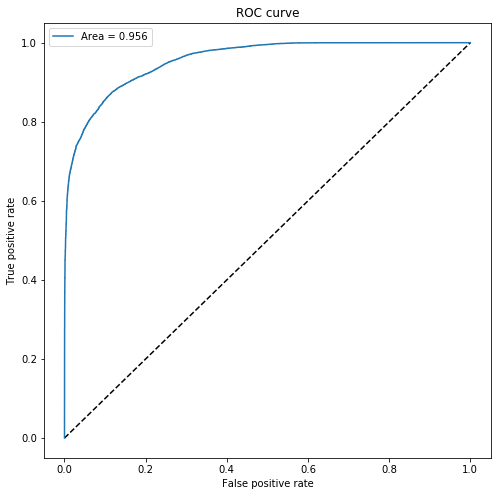

In [13]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [1]:
pwd

'/home/letitgo/jacky/lab12'